## Extension - investigating the size of disease subclusters

### Setup

Adjust the variables below as desired.

In [1]:
# The number of iterations to perform (training -> explaining -> finding subclusters)
big_loop_iterations = 10

# The number of times the explainer should be run in a single iteration (recommended: 10)
explainer_runs = 10

# Top n subclusters whose size will be analysed
n = 5

# Path to store the resulting files
filepath = "6_Jun_subclusters"

# Set up directory for result files
import os
dir = f'./results_{filepath}'
if not os.path.exists(dir):
    os.mkdir(dir)

### Load dataset

The synthetic dataset can be used for testing during development. The KIRC dataset is used for the experiment.

In [2]:
from GNNSubNet import GNNSubNet as gnn
import pandas as pd
import numpy as np

# # Kidney data set  ------------------------- #
loc   = "GNNSubNet/datasets/kirc/"
ppi   = f'{loc}/KIDNEY_RANDOM_PPI.txt'
feats = [f'{loc}/KIDNEY_RANDOM_Methy_FEATURES.txt', f'{loc}/KIDNEY_RANDOM_mRNA_FEATURES.txt']
targ  = f'{loc}/KIDNEY_RANDOM_TARGET.txt'

# Synthetic data set  ------------------------- #
# loc   = "GNNSubNet/datasets/synthetic/"
# ppi   = f'{loc}/NETWORK_synthetic.txt'
# feats = [f'{loc}/FEATURES_synthetic.txt']
# targ  = f'{loc}/TARGET_synthetic.txt'

# Read in the synthetic data
g = gnn.GNNSubNet(loc, ppi, feats, targ, normalize=False)

# Get some general information about the data dimension
g.summary()

Graph is connected  False
Calculate subgraph ...
Number of subgraphs:  118
Size of subgraph:  2049
Graph is connected  True
##################
# DATASET LOADED #
##################

Number of nodes: 2049
Number of edges: 13588
Number of modalities: 2


### Run

For the given number of big_loop_iterations, this cell trains the GNN model, runs the explainer to find the global explanation, and performs disease subnetwork detection. 

The modules found and the list of module importances in each iteration are saved in the results folder, these can be used for further analysis.

NB: running on KIRC data for 10 iterations can take 1 to 2 hours!

NB: this cell only saves the modules and module importances. The cell below this saves the table of results (containing the sizes of each subcluster). Ensure that both cells are run together to obtain the full results.

In [ ]:
accuracies = []

# number of modules
number_of_modules_found = []
# size of the top n modules
module_sizes = np.zeros((big_loop_iterations, n))

for i in range(big_loop_iterations):
    g = gnn.GNNSubNet(loc, ppi, feats, targ, normalize=False)
    g.train()
    accuracies.append(g.accuracy)
    g.explain(explainer_runs)

    # Save the actual modules and module importances to file
    filename = f"results_{filepath}/{i}_module_importances.csv"
    np.savetxt(filename, g.module_importances, delimiter = ",", fmt ='% s')
    filename = f"results_{filepath}/{i}_modules.csv"
    f = open(filename, "a")
    for m in range(len(g.modules)):
        f.write(",".join(str(x) for x in g.modules[m]))
        f.write("\n")
    f.close()

    # Add number of modules found to the list
    number_of_modules_found.append(len(g.modules))
    
    # Take the top n most important modules, 
    # and add their sizes to the list
    sorted_indices = np.argsort(g.module_importances)[::-1][:n]
    for (j, idx) in enumerate(sorted_indices):
        module_sizes[i][j] = (len(g.modules[idx]))

### Results

Save a single file, subcluster_sizes.csv, which contains the sizes of the top n subclusters found in each iteration.

In [25]:
import pandas as pd
columns = [f"size_of_module_{i}" for i in range(n)]
df = pd.DataFrame(module_sizes, columns=columns)
df.to_csv(f"results_{filepath}/subcluster_sizes.csv", index=False)

pd.DataFrame(accuracies).to_csv(f"results_{filepath}/accuracies.csv", index=False)
pd.DataFrame(number_of_modules_found).to_csv(f"results_{filepath}/number_of_modules_found.csv", index=False)

Plot model accuracy against the average size of the top n subclusters, to detect any potential correlation.

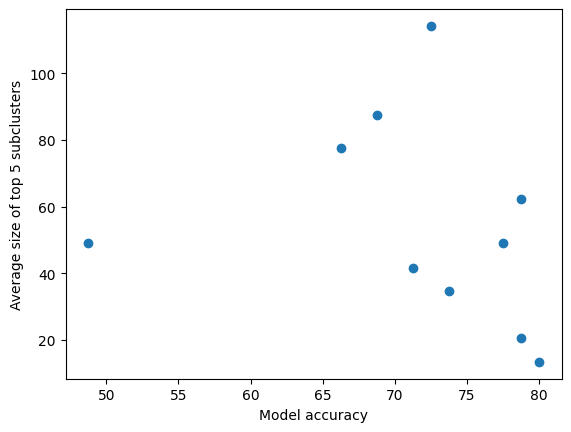

In [6]:
import matplotlib.pyplot as plt

plt.scatter(accuracies, module_sizes.mean(axis=1))
plt.xlabel("Model accuracy")
plt.ylabel(f"Average size of top {n} subclusters")
plt.show()

Examine the size of the top n subclusters. Here, the rank of subcluster is its importance. Rank 1 is the first most important subcluster, rank 2 the 2nd most important, etc.

(10, 5)


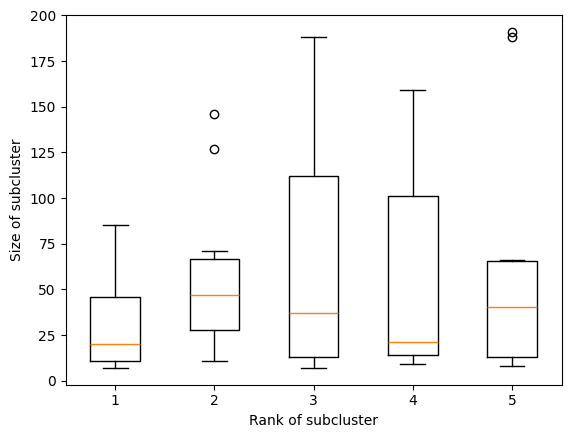

In [22]:
# module_sizes = np.zeros((big_loop_iterations, n))
print(module_sizes.shape)
plt.boxplot(module_sizes)
plt.xlabel("Subclusters ranked by importance")
plt.ylabel("Size of subcluster")
plt.show()

Observe the frequencies with which nodes are found in the most important cluster.

In [ ]:
from collections import Counter
# initialise the list
top_modules = []

for i in range(big_loop_iterations):
    # Load module importances
    filename = f"results_{filepath}/{i}_module_importances.csv"
    module_importances = np.loadtxt(filename, delimiter = ",")
    # Find the index of the highest importance
    top_idx = np.argsort(module_importances)[::-1][0]

    # Read the modules
    filename = f"results_{filepath}/{i}_modules.csv"
    with open(filename) as fp:
        for l, line in enumerate(fp):
            # Find the module with the highest importance and add its nodes to the list
            if l == top_idx:
                top_modules.extend(line.split(","))

# count the appearances of nodes in the list
print(Counter(top_modules))